# Kindergarten Demand vs Childcare Availability in Melbourne

**Author**: Muzamil Rafique  
**Tools Used**: Python, Pandas, Seaborn, Matplotlib, Folium


### Scenario

As a community planner, I want to analyse the demand for kindergarten services across Melbourne, especially for children aged 3–4. By comparing population forecasts with the number of available childcare centres, we can identify underserved suburbs, plan resources better, and improve access to early childhood education.

# Background and Introduction

In a rapidly growing city like Melbourne, the demand for early childhood education services continues to evolve alongside changing population demographics. This project focuses on understanding the **availability and accessibility of childcare centres** by combining geocoded service data with **population forecasts for children aged 0–4** across Melbourne suburbs.

By visualising where childcare centres are located and comparing it with population trends, this notebook aims to uncover areas of high demand, possible oversupply, and regions that may require future investment in childcare infrastructure.

# Datasets Used

### Childcare Centres (Geocoded):
This dataset includes service names, types, addresses, phone numbers, and geographic coordinates (latitude and longitude) for childcare centres across Melbourne. It allows for precise mapping of centres to analyse their spatial distribution.

### City of Melbourne Population Forecasts (2020–2040):
This dataset provides suburb-level forecasts for the number of children aged 0–4 over the years 2020 to 2040. It supports demand analysis for early childhood education based on projected population growth.


## Stage 1: Load & Clean Data

We load both datasets:
- **`geocoded_output.csv`** → Supply data (childcare centres with location and type)
- **`city-of-melbourne-population-forecasts-by-small-area-2020-2040.csv`** → Demand data (population forecasts by suburb and age group)

**Cleaning Steps:**
1. Standardise suburb names to uppercase and remove spaces
2. Filter the population dataset to **Age 0–4** only
3. Extract demand for **2023** and **2040**
4. Aggregate supply (number of centres) by suburb

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load datasets
supply_df = pd.read_csv("geocoded_output.csv")
demand_df = pd.read_csv("city-of-melbourne-population-forecasts-by-small-area-2020-2040.csv")

# --- Clean Supply Dataset ---
supply_df['Suburb'] = supply_df['Suburb'].str.strip().str.upper()
centre_counts = supply_df.groupby('Suburb').size().reset_index(name='CentreCount')

# --- Clean Demand Dataset ---
# Filter for Age 0–4
demand_df = demand_df[demand_df['age'] == "Age 0-4"].copy()
demand_df['geography'] = demand_df['geography'].str.strip().str.upper()

# Get 2023 and 2040 demand
pop_2023 = demand_df[demand_df['year'] == 2023.0].groupby('geography')['value'].sum().reset_index()
pop_2040 = demand_df[demand_df['year'] == 2040.0].groupby('geography')['value'].sum().reset_index()

pop_2023.rename(columns={'geography': 'Suburb', 'value': 'Pop2023'}, inplace=True)
pop_2040.rename(columns={'geography': 'Suburb', 'value': 'Pop2040'}, inplace=True)

# --- Merge datasets ---
merged_df = pd.merge(pop_2023, pop_2040, on='Suburb', how='outer')
merged_df = pd.merge(merged_df, centre_counts, on='Suburb', how='left').fillna({'CentreCount': 0})

# --- Calculate extra metrics ---
merged_df['Centres_per_1000_Children'] = (merged_df['CentreCount'] / merged_df['Pop2023']) * 1000
merged_df['Growth_%'] = ((merged_df['Pop2040'] - merged_df['Pop2023']) / merged_df['Pop2023']) * 100
merged_df['Future_Pressure'] = merged_df['Pop2040'] / merged_df['CentreCount'].replace(0, pd.NA)

# Final check
merged_df.head()


,Suburb,Pop2023,Pop2040,CentreCount,Centres_per_1000_Children,Growth_%,Future_Pressure
0,CARLTON,412.0,868.0,6.0,14.563107,110.679612,144.666667
1,CITY OF MELBOURNE,4762.0,11498.0,0.0,0.000000,141.453171,<NA>
2,DOCKLANDS,797.0,1888.0,2.0,2.509410,136.888331,944.0
3,EAST MELBOURNE,112.0,237.0,0.0,0.000000,111.607143,<NA>
4,KENSINGTON,709.0,1578.0,4.0,5.641749,122.566996,394.5


# Mapping Childcare Centres in Melbourne

An interactive map was created to visualise the spatial distribution of childcare centres across Melbourne. Each blue marker represents a childcare service, and clicking on a marker reveals details such as the centre’s name and phone number.

This helps users visually identify suburbs with high or low density of centres and allows future integration with address-based user inputs to find the nearest service.

In [11]:
import folium


# Read and clean CSV
map_df = pd.read_csv("geocoded_output.csv")
map_df.columns = map_df.columns.str.strip()  # Remove any extra spaces

# Ensure lat/lon are numeric
map_df['Latitude'] = pd.to_numeric(map_df['Latitude'], errors='coerce')
map_df['Longitude'] = pd.to_numeric(map_df['Longitude'], errors='coerce')
map_df = map_df.dropna(subset=['Latitude', 'Longitude'])

# Base map
melbourne_center = [-37.8136, 144.9631]
map_cc = folium.Map(location=melbourne_center, zoom_start=13)

# Add markers
for i, row in map_df.iterrows():
    popup_text = f"<b>{row['ServiceName']}</b><br>Phone: {row['Phone']}"
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=popup_text,
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map_cc)

map_cc

## Top 5 Suburbs by Centres per 1,000 Children (2023)
This horizontal bar chart shows which suburbs have the **highest number of childcare centres relative to the number of young children (0–4 years)**. It indicates potential oversupply or strong infrastructure presence in areas like South Yarra or Carlton.


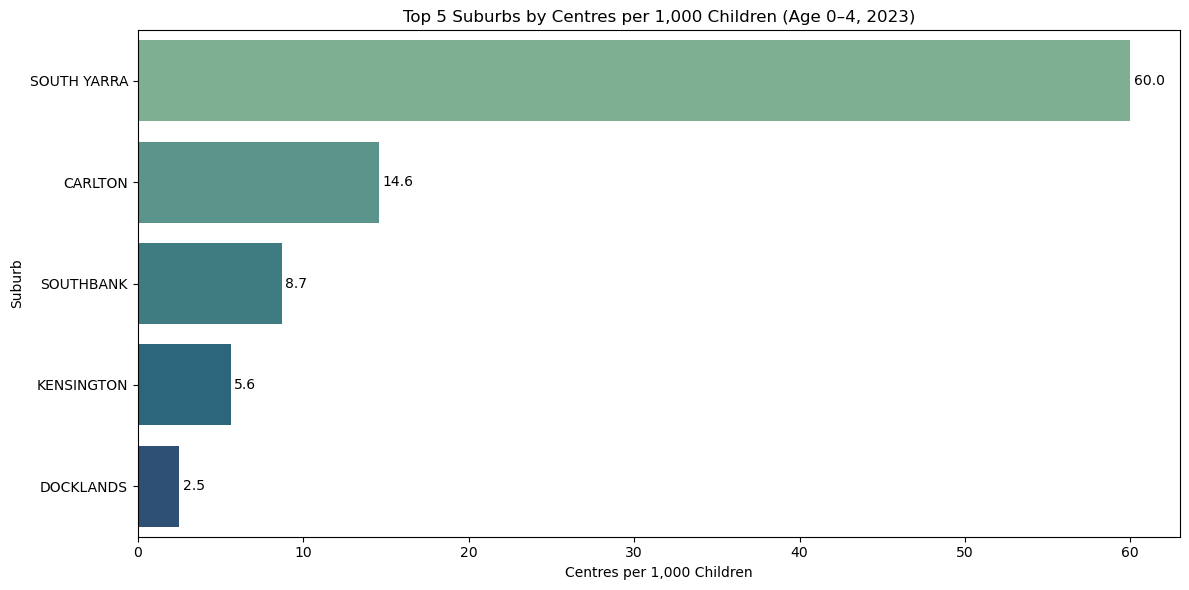

In [12]:
# Filter realistic values
plot1_df = merged_df[(merged_df['Pop2023'] >= 100) & (merged_df['CentreCount'] > 0)].copy()

# Sort and select top 15
top_suburbs = plot1_df.sort_values('Centres_per_1000_Children', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_suburbs, x='Centres_per_1000_Children', y='Suburb', palette='crest')
plt.title('Top 5 Suburbs by Centres per 1,000 Children (Age 0–4, 2023)')
plt.xlabel('Centres per 1,000 Children')
plt.ylabel('Suburb')

# Add value labels
for i, v in enumerate(top_suburbs['Centres_per_1000_Children']):
    plt.text(v + 0.2, i, f"{v:.1f}", va='center')

plt.tight_layout()
plt.show()



## Bottom 5 Underserved Suburbs (2023)

This chart highlights the suburbs with the **lowest availability** of childcare centres per 1,000 children (0–4 years old) in 2023.

**Metric:** (Number of Centres / Population Aged 0–4 in 2023) × 1000

We filter out suburbs with fewer than 100 children to avoid skewed results from very small populations.


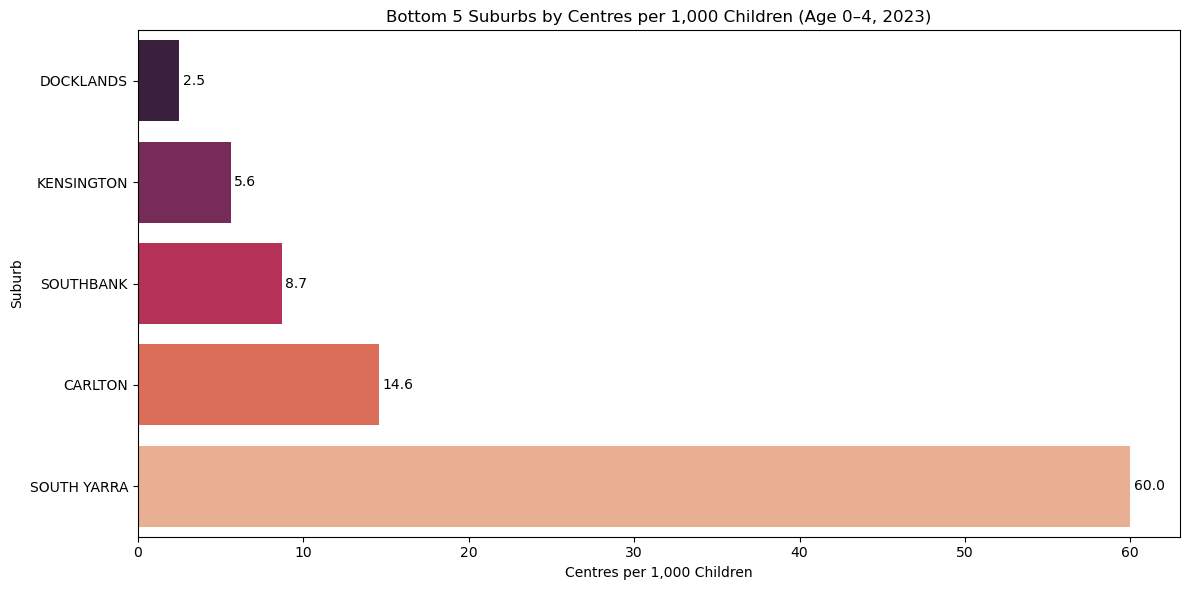

In [13]:
# Filter realistic values
plot2_df = merged_df[(merged_df['Pop2023'] >= 100) & (merged_df['CentreCount'] > 0)].copy()

# Sort ascending to find underserved
bottom_suburbs = plot2_df.sort_values('Centres_per_1000_Children', ascending=True).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=bottom_suburbs, x='Centres_per_1000_Children', y='Suburb', palette='rocket')
plt.title('Bottom 5 Suburbs by Centres per 1,000 Children (Age 0–4, 2023)')
plt.xlabel('Centres per 1,000 Children')
plt.ylabel('Suburb')

# Add value labels
for i, v in enumerate(bottom_suburbs['Centres_per_1000_Children']):
    plt.text(v + 0.2, i, f"{v:.1f}", va='center')

plt.tight_layout()
plt.show()



## Top 10 Fastest-Growing Suburbs for Age 0–4 (2023 → 2040)

This chart highlights the 10 suburbs in the City of Melbourne projected to experience the highest percentage growth in the population of 0–4-year-olds between 2023 and 2040. Suburbs like **North Melbourne**, **West Melbourne**, and **CBD** show rapid increases, which may indicate a future surge in demand for childcare facilities.

These insights can help city planners and service providers anticipate where early childhood services will be most needed in the future and plan investments accordingly.

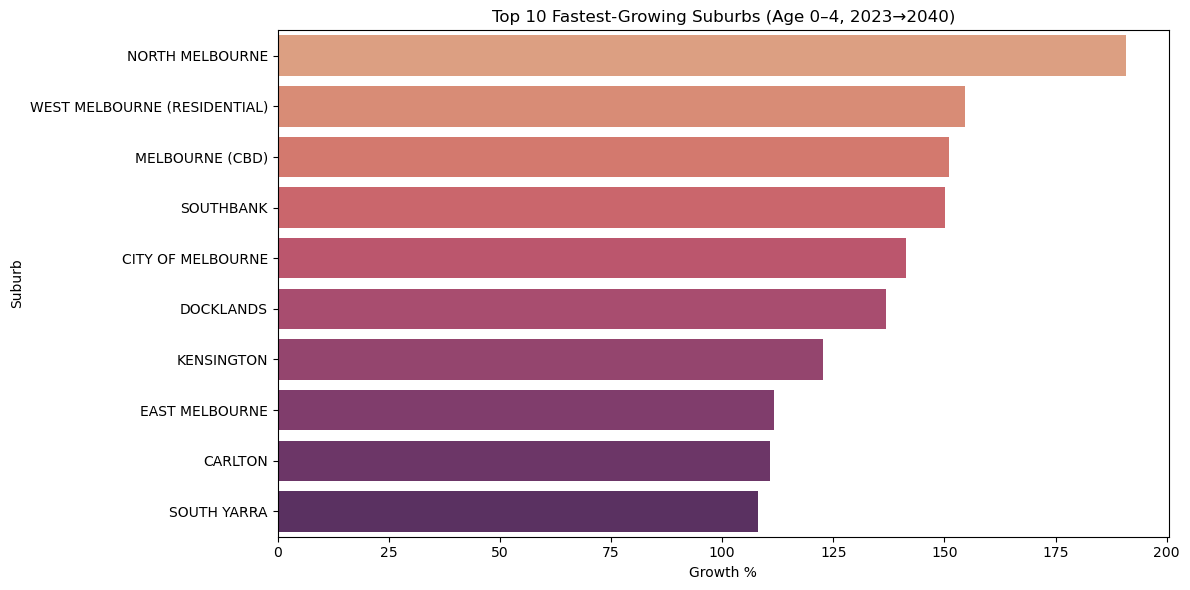

In [14]:
plot3_df = merged_df[merged_df['Pop2023'] >= 100].copy()
fastest_growth = plot3_df.sort_values('Growth_%', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=fastest_growth, x='Growth_%', y='Suburb', palette='flare')
plt.title('Top 10 Fastest-Growing Suburbs (Age 0–4, 2023→2040)')
plt.xlabel('Growth %')
plt.ylabel('Suburb')
plt.tight_layout()
plt.show()


## Future Pressure Index – Top 5 Suburbs

This visual shows the **top 5 suburbs that may experience the most pressure on childcare services by 2040**, based on projected population growth compared to the number of existing childcare centres.

The **Future Pressure Index** is calculated as the projected 2040 population of 0–4-year-olds divided by the current number of centres. A higher value indicates that a suburb may face **resource constraints** in the future unless more centres are developed.

Suburbs like **Docklands**, **Kensington**, and **Southbank** top the list, highlighting the urgent need for strategic planning and investment in early childhood infrastructure in these growing areas.



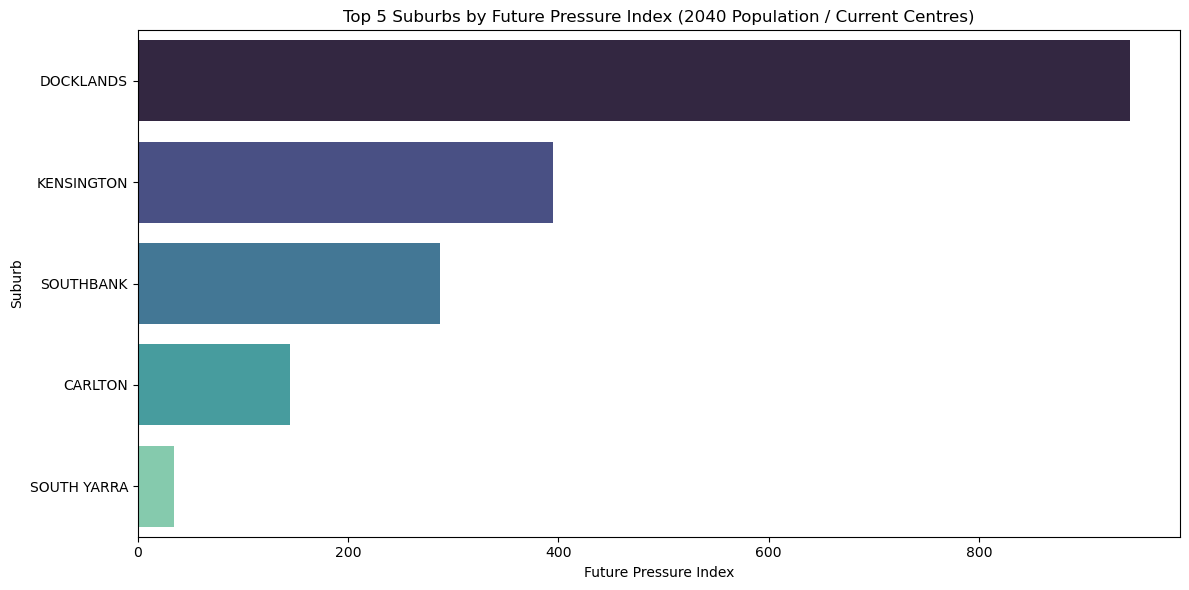

In [15]:
plot5_df = merged_df[(merged_df['Pop2023'] >= 100) & (merged_df['CentreCount'] > 0)].copy()
plot5_df = plot5_df.sort_values('Future_Pressure', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=plot5_df, x='Future_Pressure', y='Suburb', palette='mako')
plt.title('Top 5 Suburbs by Future Pressure Index (2040 Population / Current Centres)')
plt.xlabel('Future Pressure Index')
plt.ylabel('Suburb')
plt.tight_layout()
plt.show()


## Service Type Popularity – Childcare Centres

This bar chart displays the distribution of different childcare service types found in the dataset. It highlights how common each service type is across all listed centres.

From the chart, it's evident that **Centre-Based Care** dominates the landscape, accounting for the vast majority of services. **Family Day Care** is much less common in comparison.

This insight is useful for parents comparing service models, and for planners considering the availability and diversity of childcare options across Melbourne.


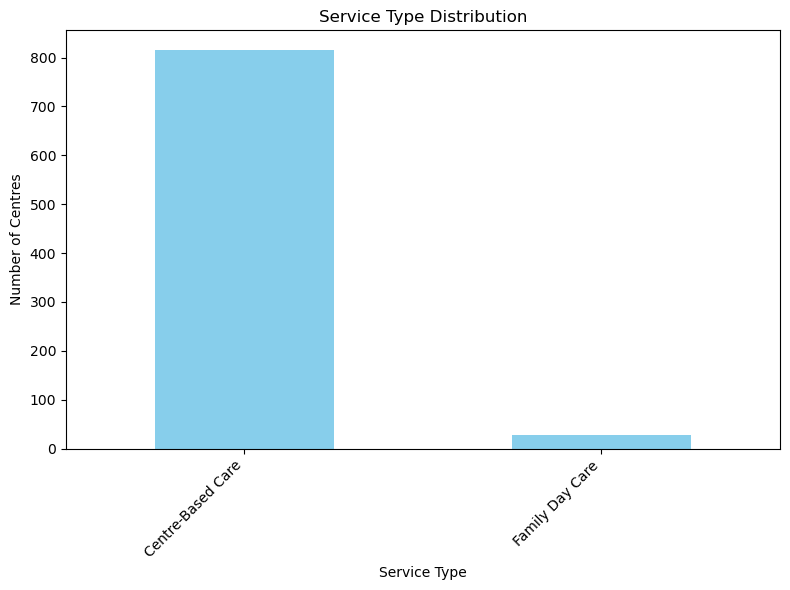

In [16]:
plt.figure(figsize=(8, 6))
supply_df['ServiceType'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Service Type Distribution')
plt.xlabel('Service Type')
plt.ylabel('Number of Centres')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Population Forecast Trend (Age 0–4)

This line chart visualizes the projected population growth for children aged 0–4 years across the top five most populated suburbs (as of 2023). The data spans from 2023 to 2043.

The purpose of this chart is to identify suburbs with consistently increasing demand for early childhood education services over time. As seen in the chart, **City of Melbourne** is expected to experience the most significant growth, followed by **Melbourne (CBD)** and **Docklands**.

These trends can guide government planners and local councils in anticipating future childcare infrastructure needs, helping them prioritize investment in areas likely to face the highest population pressure.



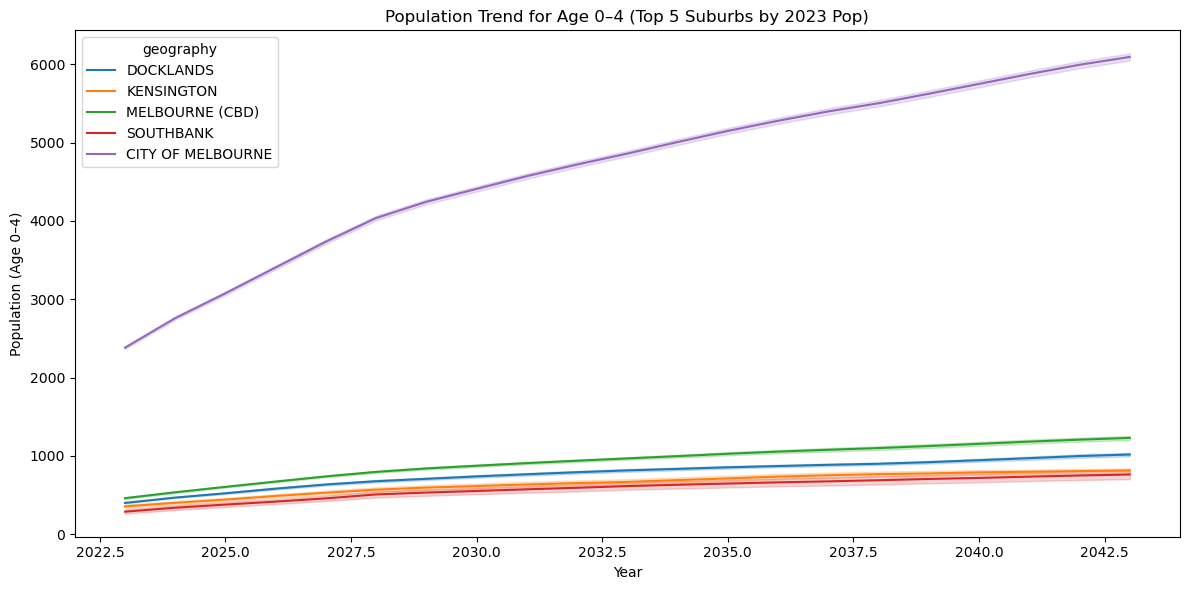

In [17]:
trend_df = demand_df[demand_df['age'] == "Age 0-4"]
trend_df['geography'] = trend_df['geography'].str.strip().str.upper()

selected_suburbs = merged_df.sort_values('Pop2023', ascending=False).head(5)['Suburb']
trend_df = trend_df[trend_df['geography'].isin(selected_suburbs)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_df, x='year', y='value', hue='geography')
plt.title('Population Trend for Age 0–4 (Top 5 Suburbs by 2023 Pop)')
plt.xlabel('Year')
plt.ylabel('Population (Age 0–4)')
plt.tight_layout()
plt.show()


## Demand vs. Supply Grid (Top & Bottom Suburbs)

This grid compares the top and bottom suburbs based on two key aspects:

- **Demand**: Number of children aged 0–4 in 2023  
- **Supply**: Number of childcare centres in each suburb  

By looking at these together, we can quickly identify areas with potential mismatches between demand and service availability.

**Key observations from the chart:**

- **City of Melbourne** has the highest number of young children, suggesting strong current and future demand.
- **Werribee** and **Tarneit** are leading in terms of childcare centre availability, reflecting high service coverage.
- **Port Melbourne** appears among both the lowest for demand and supply — a suburb that may require future monitoring.
- **East Melbourne** and **South Yarra** show low demand but also limited centre availability.

This chart helps planners identify priority areas for expanding or adjusting childcare infrastructure to meet the needs of local communities.



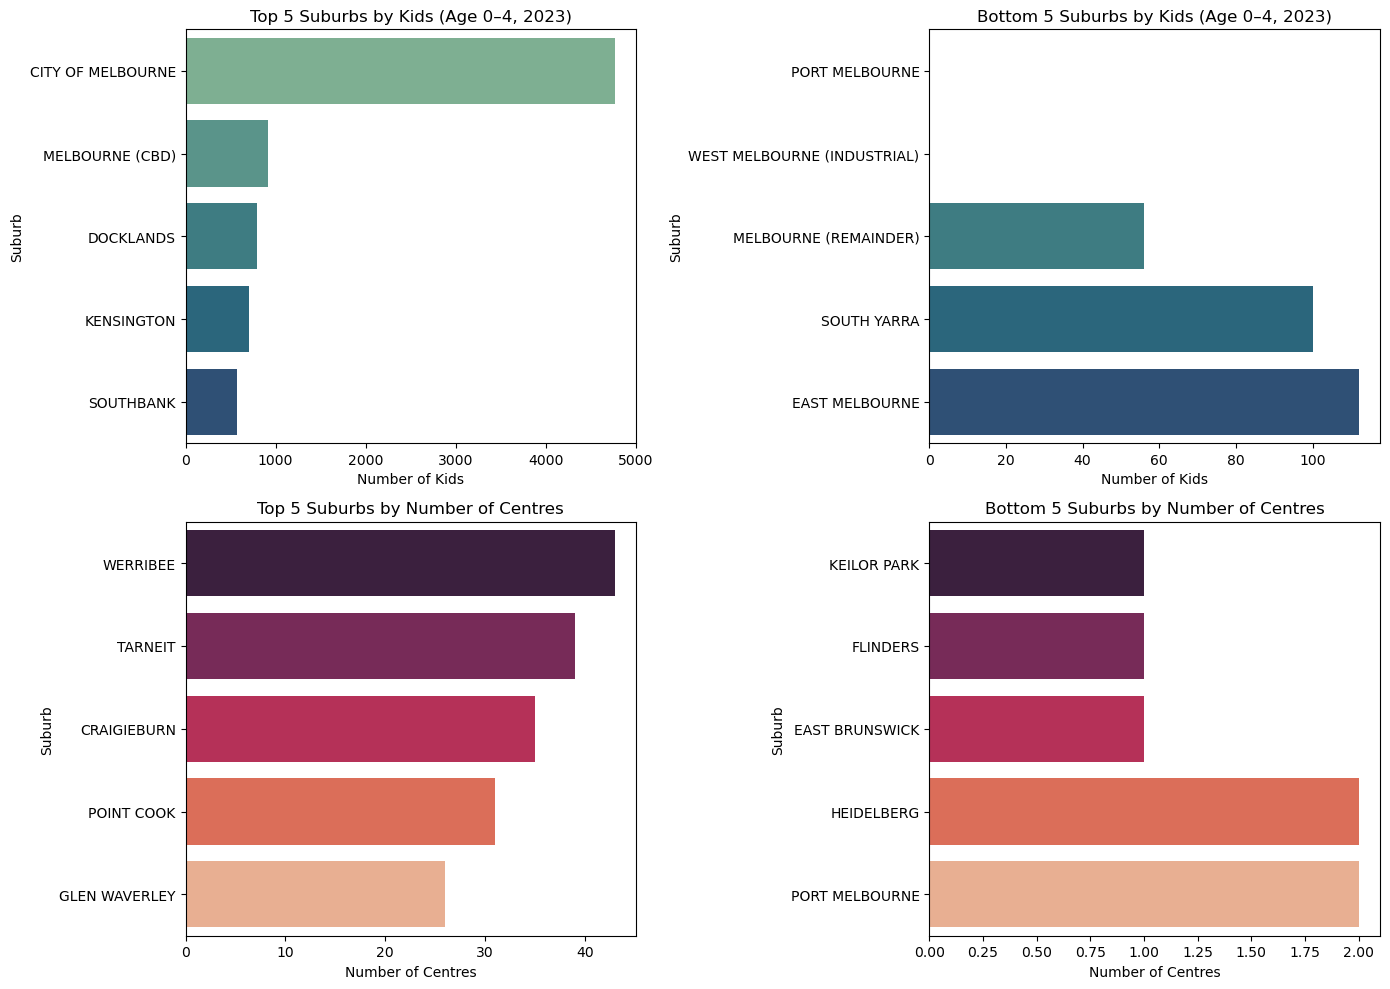

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load datasets
pop_df = pd.read_csv("city-of-melbourne-population-forecasts-by-small-area-2020-2040.csv")
centres_df = pd.read_csv("geocoded_output.csv")

# --- Demand: Kids aged 0–4 in 2023 ---
pop_df['geography'] = pop_df['geography'].str.strip().str.upper()
pop_2023 = pop_df[(pop_df['age'] == "Age 0-4") & (pop_df['year'] == 2023.0)]
pop_agg = pop_2023.groupby('geography')['value'].sum().reset_index(name='Kids2023')

# Top & bottom 5 suburbs by kids
top_kids = pop_agg.sort_values('Kids2023', ascending=False).head(5)
bottom_kids = pop_agg.sort_values('Kids2023', ascending=True).head(5)

# --- Supply: Childcare centres ---
centres_df['Suburb'] = centres_df['Suburb'].str.strip().str.upper()
centre_counts = centres_df.groupby('Suburb').size().reset_index(name='CentreCount')

# Top & bottom 5 suburbs by centres
top_centres = centre_counts.sort_values('CentreCount', ascending=False).head(5)
bottom_centres = centre_counts.sort_values('CentreCount', ascending=True).head(5)

# --- Plot ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top kids
sns.barplot(data=top_kids, x='Kids2023', y='geography', ax=axes[0, 0], palette='crest')
axes[0, 0].set_title("Top 5 Suburbs by Kids (Age 0–4, 2023)")
axes[0, 0].set_xlabel("Number of Kids")
axes[0, 0].set_ylabel("Suburb")

# Bottom kids
sns.barplot(data=bottom_kids, x='Kids2023', y='geography', ax=axes[0, 1], palette='crest')
axes[0, 1].set_title("Bottom 5 Suburbs by Kids (Age 0–4, 2023)")
axes[0, 1].set_xlabel("Number of Kids")
axes[0, 1].set_ylabel("Suburb")

# Top centres
sns.barplot(data=top_centres, x='CentreCount', y='Suburb', ax=axes[1, 0], palette='rocket')
axes[1, 0].set_title("Top 5 Suburbs by Number of Centres")
axes[1, 0].set_xlabel("Number of Centres")
axes[1, 0].set_ylabel("Suburb")

# Bottom centres
sns.barplot(data=bottom_centres, x='CentreCount', y='Suburb', ax=axes[1, 1], palette='rocket')
axes[1, 1].set_title("Bottom 5 Suburbs by Number of Centres")
axes[1, 1].set_xlabel("Number of Centres")
axes[1, 1].set_ylabel("Suburb")

plt.tight_layout()
plt.show()


---

## 📍 Childcare Finder Tools

This section introduces two interactive tools built to assist families in locating childcare services efficiently:


In [19]:
def find_childcare_centres():
    # Load and clean dataset
    df = pd.read_csv("geocoded_output.csv")
    df.columns = df.columns.str.strip()
    df['Suburb'] = df['Suburb'].str.strip().str.upper()
    df['ServiceType'] = df['ServiceType'].str.strip().str.upper()

    # Get user input
    user_suburb = input("Enter your suburb: ").strip().upper()
    user_type = input("Enter care type (CENTRE BASED / FAMILY DAY CARE): ").strip().upper()

    # Filter based on input
    filtered = df[(df['Suburb'] == user_suburb) & (df['ServiceType'] == user_type)]

    # Display results
    if not filtered.empty:
        print(f"\nFound {len(filtered)} centres in {user_suburb} for {user_type}:\n")
        print(filtered[['ServiceType', 'Address', 'Suburb', 'Phone']].to_string(index=False))
    else:
        print("\nSorry, no matching centres found.")

## Tool 1: Suburb & Service Type Filter

**Instructions:**
- Enter a **suburb** and choose a **service type** (e.g. CENTRE BASED / FAMILY DAY CARE).
- The tool filters and displays a list of centres in that suburb matching the selected service type.

**Usefulness:**
- Quickly identify all matching childcare centres near your location, including their address and contact number.


In [20]:
find_childcare_centres()

Enter your suburb: Carlton
Enter care type (CENTRE BASED / FAMILY DAY CARE): Centre-Based Care

Found 6 centres in CARLTON for CENTRE-BASED CARE:

      ServiceType                Address  Suburb        Phone
CENTRE-BASED CARE   201-215 Rathdowne St CARLTON    431608071
CENTRE-BASED CARE        2-10 Grattan St CARLTON    393474949
CENTRE-BASED CARE         17-25 Lygon St CARLTON 03 9925 8500
CENTRE-BASED CARE 228 Queensberry Street CARLTON    383449470
CENTRE-BASED CARE       59-65 Station St CARLTON    405696022
CENTRE-BASED CARE    856 Swanston Street CARLTON    390354300


## Tool 2: Nearest Centre Locator

**Usefulness:**
- Ideal for finding the closest childcare option to your home address for convenience and reduced travel time.

In [21]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

# Load geocoded childcare dataset
df = pd.read_csv("geocoded_output.csv")
df.columns = df.columns.str.strip()  # Remove any trailing spaces

# --- Clean data ---
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
df.dropna(subset=['Latitude', 'Longitude'], inplace=True)
df['Suburb'] = df['Suburb'].str.strip().str.upper()
df['ServiceType'] = df['ServiceType'].str.strip().str.upper()

# Create widget dropdowns
suburb_dropdown = widgets.Dropdown(
    options=sorted(df['Suburb'].unique()),
    description='Suburb:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

service_dropdown = widgets.Dropdown(
    options=sorted(df['ServiceType'].unique()),
    description='Service Type:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

address_input = widgets.Text(
    placeholder='Enter your address (e.g. 123 Swanston St, Melbourne)',
    description='Your Address:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)

submit_button = widgets.Button(
    description="Find Nearest Centre",
    button_style='success'
)

output = widgets.Output()

def find_nearest_centre(b):
    with output:
        clear_output()
        
        # Geocode the address
        geolocator = Nominatim(user_agent="childcare_locator")
        location = geolocator.geocode(address_input.value)
        
        if location is None:
            print("❌ Could not geocode your address. Please try again.")
            return

        user_coords = (location.latitude, location.longitude)
        
        # Filter dataset by suburb and service type
        filtered = df[
            (df['Suburb'] == suburb_dropdown.value) & 
            (df['ServiceType'] == service_dropdown.value)
        ]

        if filtered.empty:
            print("❌ No childcare centres found with this combination.")
            return

        # Calculate distances
        filtered['Distance_km'] = filtered.apply(
            lambda row: geodesic(user_coords, (row['Latitude'], row['Longitude'])).km,
            axis=1
        )

        nearest = filtered.sort_values('Distance_km').iloc[0]

        print(f"✅ Nearest Centre: {nearest['ServiceName']}")
        print(f"📍 Address: {nearest['Address']}, {nearest['Suburb']}")
        print(f"📞 Phone: {nearest['Phone']}")
        print(f"📏 Distance: {nearest['Distance_km']:.2f} km")

submit_button.on_click(find_nearest_centre)


**Instructions:**
- Select a **suburb**, **service type**, and enter your **home address**.
- The tool uses geolocation to find and display the nearest matching childcare centre along with the distance.


In [22]:

# Display widgets
display(widgets.VBox([suburb_dropdown, service_dropdown, address_input, submit_button, output]))